# Inspecting encoded spike train
### as grayscale image

## 1. Training the STAL Encoder

With no Z1 Z2 in the loss func

torch.Size([784]) tensor(5)
Total Learnable Parameters (STAL): 39200


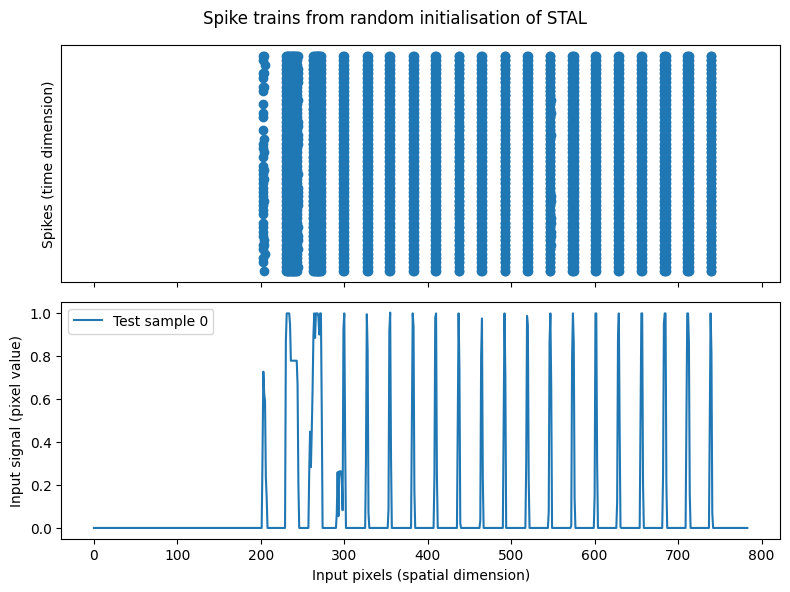

Default Loss initialized.
Epoch 1 - Train Loss: -338.101
	- Validation Loss: -339.446
Epoch 2 - Train Loss: -340.450
	- Validation Loss: -340.066
Epoch 3 - Train Loss: -340.845
	- Validation Loss: -340.228
Epoch 4 - Train Loss: -341.283
	- Validation Loss: -340.892
Epoch 5 - Train Loss: -342.050
	- Validation Loss: -341.634
Epoch 6 - Train Loss: -342.756
	- Validation Loss: -342.246
Epoch 7 - Train Loss: -343.393
	- Validation Loss: -342.868
Epoch 8 - Train Loss: -344.100
	- Validation Loss: -343.545
Epoch 9 - Train Loss: -344.860
	- Validation Loss: -344.221
Epoch 10 - Train Loss: -345.624
	- Validation Loss: -344.924
Epoch 11 - Train Loss: -346.411
	- Validation Loss: -345.681
Epoch 12 - Train Loss: -347.228
	- Validation Loss: -346.465
Epoch 13 - Train Loss: -348.062
	- Validation Loss: -347.263
Epoch 14 - Train Loss: -348.913
	- Validation Loss: -348.073
Epoch 15 - Train Loss: -349.780
	- Validation Loss: -348.898
Epoch 16 - Train Loss: -350.660
	- Validation Loss: -349.743
Epoch 1

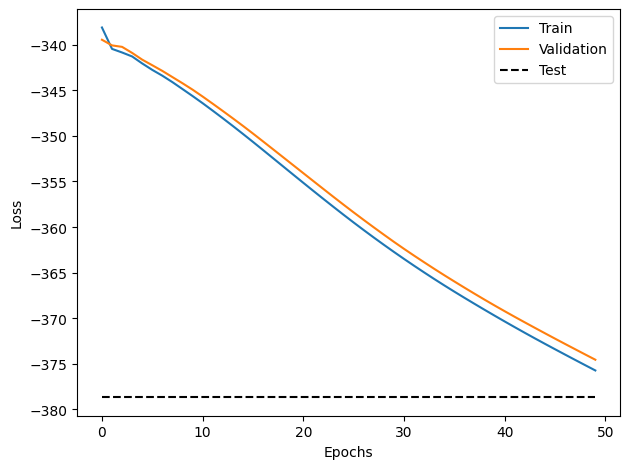

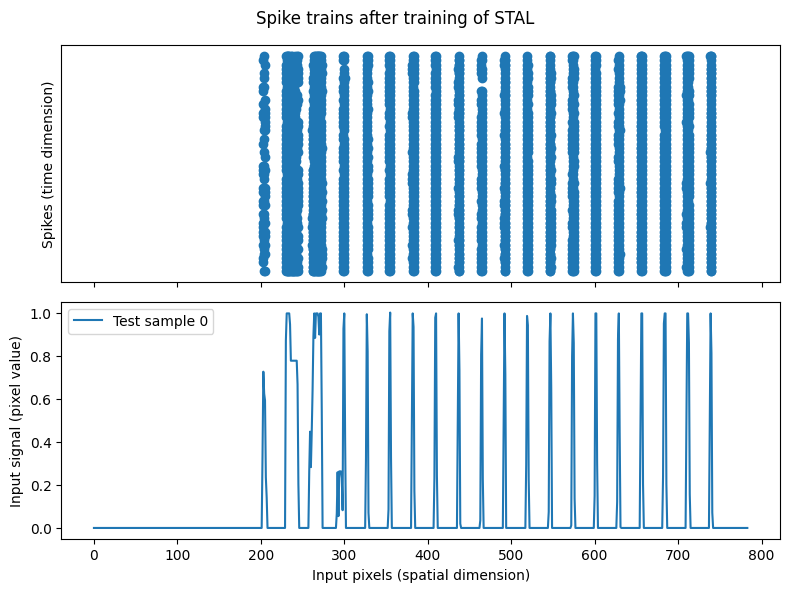

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import time

from mnist.load_mnist import load_mnist
from STAL.STAL import SpikeThresholdAdaptiveLearning
# from STAL_loss.loss_low_sp import DefaultLoss
from STAL_loss.default_loss import DefaultLoss

device = torch.device("mps")

train_X, train_y, test_X, test_y = load_mnist()

# test_X = test_X[:1000] # TODO: revert this
# test_y = test_y[:1000]

print(train_X[0].shape, train_y[0])

omega = train_X[0].size(0)
psi = 50
c = 1
l1_sz = 0 # omega // 2 # 392
l2_sz = 0 # omega // 4 # 196
drop_p = 0.5

STAL = SpikeThresholdAdaptiveLearning(omega, psi, c, l1_sz, l2_sz, drop_p)
STAL.print_learnable_params()

batch_size = 10000
x = test_X[:batch_size]

h, Z1, Z2 = STAL(x)

theta = 0.99
spiketrain = (h > theta).float()
# [batch_size, (window_size * n_channels) * psi]

# Since we have 1 channel, let's squeeze it
B = spiketrain.reshape(batch_size, omega, c, psi).squeeze(2)

b = B[0]
pixels, spikes = np.where(b == 1)

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axs[0].scatter(pixels, (spikes/psi))
axs[0].set_ylabel("Spikes (time dimension)")
axs[0].set_yticks([])

axs[1].plot(x[0], label="Test sample 0")
axs[1].set_xlabel("Input pixels (spatial dimension)")
axs[1].set_ylabel("Input signal (pixel value)")
axs[1].legend()

plt.suptitle("Spike trains from random initialisation of STAL")
plt.tight_layout()
# plt.savefig("img/random_init_example_mnist.png")
plt.show()

# Loss and Optimizer
default_loss = DefaultLoss()
optimizer = torch.optim.AdamW(STAL.parameters(), lr=0.001)

# Train/Validation
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
n_epochs = 50
# train_X = train_X[:batch_size*10] # TODO: revert this
# val_X = val_X[:batch_size*3]
# train_y = train_y[:batch_size*10]
# val_y = val_y[:batch_size*3]

STAL.to(device)

start = time.time()

train_loss = []
train_spiketrains = []
val_loss = []
val_spiketrains = []
for epoch in range(n_epochs):
    e = []
    for i in range(0, len(train_X), batch_size):
        x_train = train_X[i:i+batch_size].to(device)
        optimizer.zero_grad()
        h, Z1, Z2 = STAL(x_train)
        if epoch == n_epochs - 1:
            spiketrain = (h > theta).float()
            train_spiketrains = np.append(train_spiketrains, spiketrain.detach().cpu().numpy())
        loss = default_loss(h, x_train, Z1, Z2)
        loss.backward()
        optimizer.step()
        e.append(loss.item())
    train_loss.append(np.mean(e))
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss[-1]:.3f}")
    
    e = []
    with torch.no_grad():
        for i in range(0, len(val_X), batch_size):
            x_val = val_X[i:i+batch_size].to(device)
            h, Z1, Z2 = STAL(x_val)
            if epoch == n_epochs - 1:
                spiketrain = (h > theta).float()
                val_spiketrains = np.append(val_spiketrains, spiketrain.detach().cpu().numpy())
            loss = default_loss(h, x_val, Z1, Z2)
            e.append(loss.item())
    val_loss.append(np.mean(e))
    print(f"\t- Validation Loss: {val_loss[-1]:.3f}")

# Test
test_loss = []
test_spiketrains = []
for i in range(0, len(test_X), batch_size):
    x_test = test_X[:batch_size].to(device)
    h, Z1, Z2 = STAL(x_test)
    spiketrain = (h > theta).float()
    test_spiketrains = np.append(test_spiketrains, spiketrain.detach().cpu().numpy())
    loss = default_loss(h, x_test, Z1, Z2)
    test_loss.append(loss.item())

print("---")
print(f"Test Loss: {np.mean(test_loss):.3f}")
print("---")

end = time.time()
print(f"Training took {end-start:.2f}s")

def plot_loss(train_loss, val_loss, test_loss):
    plt.plot(train_loss, label="Train")
    plt.plot(val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.hlines(np.mean(test_loss), 0, len(train_loss) - 1, colors='black', linestyles='dashed', label="Test")
    plt.legend()
    plt.tight_layout()
    # plt.savefig("img/loss_curves_STAL_mnist")
    plt.show()

plot_loss(train_loss, val_loss, test_loss)

# Inspect the spike train after training
STAL.cpu()
STAL.eval()

B_STAL_tr = train_spiketrains.reshape(-1, omega, c, psi).squeeze(2)
B_STAL_val = val_spiketrains.reshape(-1, omega, c, psi).squeeze(2)
B_STAL_ts = test_spiketrains.reshape(-1, omega, c, psi).squeeze(2)
b = B_STAL_ts[0]
pixels, spikes = np.where(b == 1)

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axs[0].scatter(pixels, (spikes/psi))
axs[0].set_ylabel("Spikes (time dimension)")
axs[0].set_yticks([])

axs[1].plot(x[0], label="Test sample 0")
axs[1].set_xlabel("Input pixels (spatial dimension)")
axs[1].set_ylabel("Input signal (pixel value)")
axs[1].legend()

plt.suptitle("Spike trains after training of STAL")
plt.tight_layout()
# plt.savefig("img/post_training_example_mnist_low_sp.png")
plt.show()

B_STAL_tr = torch.tensor(B_STAL_tr)
B_STAL_val = torch.tensor(B_STAL_val)
B_STAL_ts = torch.tensor(B_STAL_ts)


## 2. Inspecting the encoded spike trains

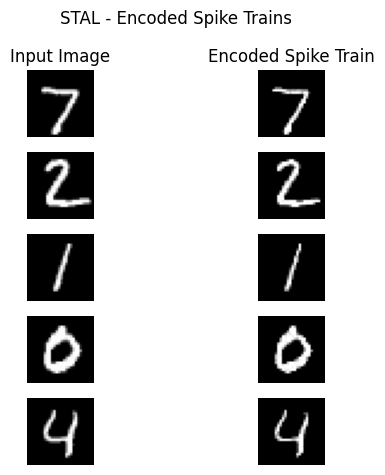

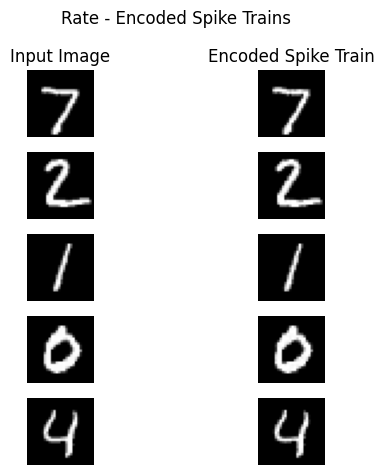

In [2]:
import snntorch as snn
from snntorch import spikegen

def plot_images(X, B, idx, title):
    fig, axs = plt.subplots(len(idx), 2)
    if len(idx) == 1:
        axs = [axs]
    
    axs[0, 0].set_title("Input Image")
    axs[0, 1].set_title("Encoded Spike Train")
    for i in idx:
        x = X[i].numpy()
        b = B[i]
        b_gray = b.mean(axis=1)
        
        axs[i, 0].imshow(x.reshape(28, 28), cmap='gray')

        axs[i, 1].imshow(b_gray.reshape(28, 28), cmap='gray')

    # Remove border
    for ax in axs.flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.set_xticks([])
    plt.suptitle(f"{title} - Encoded Spike Trains")
    plt.tight_layout()

plot_images(test_X, B_STAL_ts, np.arange(5), "STAL")

# Swap indices to match B_STAL's shape
B_rate_tr = spikegen.rate(train_X, psi).permute(1, 2, 0)
B_rate_val = spikegen.rate(val_X, psi).permute(1, 2, 0)
B_rate_ts = spikegen.rate(test_X, psi).permute(1, 2, 0)
plot_images(test_X, B_rate_ts, np.arange(5), "Rate")

Converting the spiketrains to the format for snntorch: [spike dim, batch size, input size], i.e.: [psi, batch_size, num_pixels].

In [3]:
print(B_rate_ts.shape, B_STAL_ts.shape)
# bsz, pixels, psi -> psi, bsz, pixels

B_rate_tr = B_rate_tr.permute(2, 0, 1)
B_rate_val = B_rate_val.permute(2, 0, 1)
B_rate_ts = B_rate_ts.permute(2, 0, 1)

B_STAL_tr = B_STAL_tr.permute(2, 0, 1)
B_STAL_val = B_STAL_val.permute(2, 0, 1)
B_STAL_ts = B_STAL_ts.permute(2, 0, 1)

print(B_rate_ts.shape, B_STAL_ts.shape)
# psi, bsz, pixels


torch.Size([10000, 784, 50]) torch.Size([10000, 784, 50])
torch.Size([50, 10000, 784]) torch.Size([50, 10000, 784])


## 3. Training simple SNN

a. Train the SNN on rate-coded spike trains \
b. Train it on the STAL spike trains \
c. Compare the performances.

In [4]:
class MNIST_SNN(torch.nn.Module):
    def __init__(self):
        super(MNIST_SNN, self).__init__()
        self.lif = snn.LeakyParallel(input_size=28*28, hidden_size=10)
        
    def forward(self, x):
        spk = self.lif(x)
        return spk
    
snn_model = MNIST_SNN()
snn_model

MNIST_SNN(
  (lif): LeakyParallel(
    (rnn): RNN(784, 10)
  )
)

The training logic:

In [11]:
from snntorch import functional as SF

def train_test(B_tr, train_y, B_val, val_y, B_ts, test_y, spiking_loss, accuracy_score, cls_epochs=50, lr=0.01):
    snn_model = MNIST_SNN()
    snn_model.to(device)
    optimizer = torch.optim.AdamW(snn_model.parameters(), lr=lr)

    # Train
    train_loss = []
    val_loss = []

    start = time.time()
    for epoch in range(cls_epochs):
        e = []
        for i in range(0, len(B_tr), batch_size):
            x_train = B_tr[:, i:i+batch_size].float().to(device)
            y_train = train_y[i:i+batch_size].long().to(device)
            optimizer.zero_grad()

            spk = snn_model(x_train)
            loss = spiking_loss(spk, y_train)
            loss.backward()
            optimizer.step()
            e.append(loss.item())
        train_loss.append(np.mean(e))
        print(f"Epoch {epoch + 1} - Train Loss: {train_loss[-1]:.3f}")
        
        # Validation
        e = []
        with torch.no_grad():
            for i in range(0, len(B_val), batch_size):
                x_val = B_val[:, i:i+batch_size].float().to(device)
                y_val = val_y[i:i+batch_size].long().to(device)
                spk = snn_model(x_val)
                loss = spiking_loss(spk, y_val)
                e.append(loss.item())
        val_loss.append(np.mean(e))
        print(f"\t- Validation Loss: {val_loss[-1]:.3f}")
        
    # Test
    e = []
    test_loss = []
    test_acc = []
    with torch.no_grad():
        for i in range(0, len(B_ts), batch_size):
            x_test = B_ts[:, i:i+batch_size].float().to(device)
            y_test = test_y[i:i+batch_size].long().to(device)
            
            spk = snn_model(x_test)
            loss = spiking_loss(spk, y_test)
            test_loss.append(loss.item())

            test_acc.append(accuracy_score(spk, y_test))
            e.append(loss.item())

    plot_loss(train_loss, val_loss, test_loss)

    print(f"Test Loss: {np.mean(e):.3f}")
    print(f"Rate: {np.mean(test_acc)*100:.2f}% accuracy on test set")

    end = time.time()
    print(f"Training took {end-start:.2f}s")
    
    return np.mean(test_acc)*100

#### a. Train on Rate

Epoch 1 - Train Loss: 2.338
	- Validation Loss: 2.211
Epoch 2 - Train Loss: 2.212
	- Validation Loss: 2.114
Epoch 3 - Train Loss: 2.114
	- Validation Loss: 2.043
Epoch 4 - Train Loss: 2.042
	- Validation Loss: 1.992
Epoch 5 - Train Loss: 1.990
	- Validation Loss: 1.952
Epoch 6 - Train Loss: 1.950
	- Validation Loss: 1.921
Epoch 7 - Train Loss: 1.916
	- Validation Loss: 1.894
Epoch 8 - Train Loss: 1.888
	- Validation Loss: 1.871
Epoch 9 - Train Loss: 1.864
	- Validation Loss: 1.849
Epoch 10 - Train Loss: 1.842
	- Validation Loss: 1.829
Epoch 11 - Train Loss: 1.823
	- Validation Loss: 1.811
Epoch 12 - Train Loss: 1.804
	- Validation Loss: 1.796
Epoch 13 - Train Loss: 1.789
	- Validation Loss: 1.785
Epoch 14 - Train Loss: 1.778
	- Validation Loss: 1.775
Epoch 15 - Train Loss: 1.769
	- Validation Loss: 1.767
Epoch 16 - Train Loss: 1.761
	- Validation Loss: 1.759
Epoch 17 - Train Loss: 1.753
	- Validation Loss: 1.751
Epoch 18 - Train Loss: 1.745
	- Validation Loss: 1.744
Epoch 19 - Train Lo

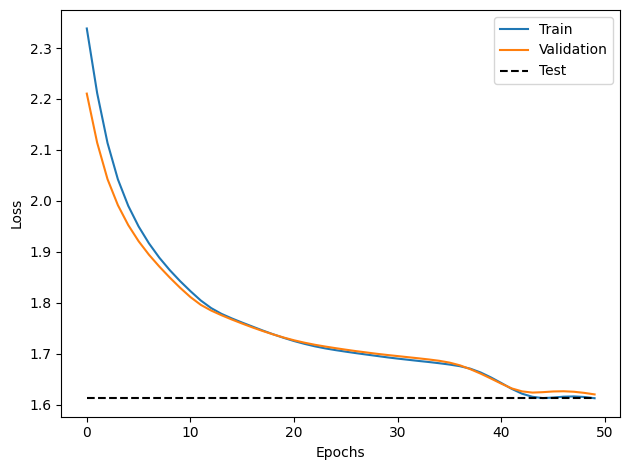

Test Loss: 1.613
Rate: 66.54% accuracy on test set
Training took 20.01s


In [12]:
# Rate 1: rate loss and rate used to compute accuracy
spiking_loss = SF.ce_rate_loss()
accuracy_score = SF.acc.accuracy_rate

test_acc_rate1 = train_test(B_rate_tr, train_y, B_rate_val, val_y, B_rate_ts, test_y, spiking_loss, accuracy_score)

In [ ]:
# Rate 2: temporal loss and temporal dimension used to compute accuracy
spiking_loss = SF.ce_temporal_loss()
accuracy_score = SF.acc.accuracy_temporal

test_acc_rate2 = train_test(B_rate_tr, train_y, B_rate_val, val_y, B_rate_ts, test_y, spiking_loss, accuracy_score)

#### b. Train on STAL

Epoch 1 - Train Loss: 2.434
	- Validation Loss: 2.356
Epoch 2 - Train Loss: 2.353
	- Validation Loss: 2.285
Epoch 3 - Train Loss: 2.280
	- Validation Loss: 2.218
Epoch 4 - Train Loss: 2.212
	- Validation Loss: 2.155
Epoch 5 - Train Loss: 2.151
	- Validation Loss: 2.099
Epoch 6 - Train Loss: 2.095
	- Validation Loss: 2.051
Epoch 7 - Train Loss: 2.045
	- Validation Loss: 2.008
Epoch 8 - Train Loss: 2.002
	- Validation Loss: 1.971
Epoch 9 - Train Loss: 1.963
	- Validation Loss: 1.941
Epoch 10 - Train Loss: 1.932
	- Validation Loss: 1.917
Epoch 11 - Train Loss: 1.909
	- Validation Loss: 1.898
Epoch 12 - Train Loss: 1.890
	- Validation Loss: 1.884
Epoch 13 - Train Loss: 1.877
	- Validation Loss: 1.873
Epoch 14 - Train Loss: 1.866
	- Validation Loss: 1.863
Epoch 15 - Train Loss: 1.857
	- Validation Loss: 1.854
Epoch 16 - Train Loss: 1.848
	- Validation Loss: 1.846
Epoch 17 - Train Loss: 1.840
	- Validation Loss: 1.837
Epoch 18 - Train Loss: 1.831
	- Validation Loss: 1.827
Epoch 19 - Train Lo

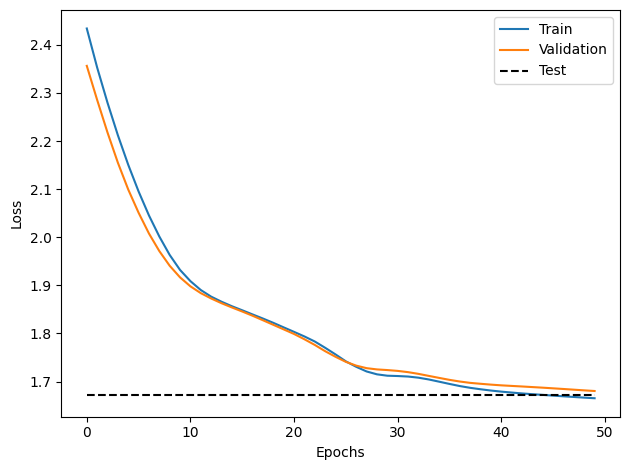

Test Loss: 1.672
Rate: 72.43% accuracy on test set
Training took 58.19s


In [13]:
# STAL 1: rate loss and rate used to compute accuracy
spiking_loss = SF.ce_rate_loss()
accuracy_score = SF.acc.accuracy_rate

test_acc_stal1 = train_test(B_STAL_tr, train_y, B_STAL_val, val_y, B_STAL_ts, test_y, spiking_loss, accuracy_score)

In [ ]:
# STAL 2: temporal loss and temporal dimension used to compute accuracy
spiking_loss = SF.ce_temporal_loss()
accuracy_score = SF.acc.accuracy_temporal

test_acc_stal2 = train_test(B_STAL_tr, train_y, B_STAL_val, val_y, B_STAL_ts, test_y, spiking_loss, accuracy_score)

#### c. Compare Rate v. STAL

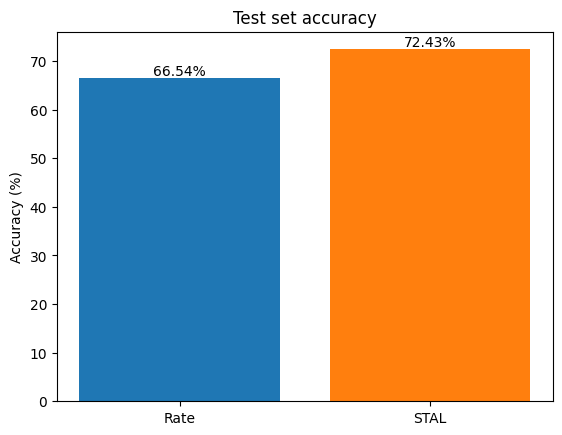

In [14]:
c = plt.cm.tab10.colors

fig, axs = plt.subplots(1, 2, figsize=(8, 6))
axs[0].bar(["Rate", "STAL"], [test_acc_rate1, test_acc_stal1], color=c)
axs[0].text(0, test_acc_rate1, f"{test_acc_rate1:.2f}%", ha='center', va='bottom')
axs[0].text(1, test_acc_stal1, f"{test_acc_stal1:.2f}%", ha='center', va='bottom')
axs[0].set_ylabel("Accuracy (%)")
axs[0].set_title("CE Rate loss + Rate Accuracy")

axs[0].bar(["Rate", "STAL"], [test_acc_rate2, test_acc_stal2], color=c)
axs[0].text(0, test_acc_rate2, f"{test_acc_rate2:.2f}%", ha='center', va='bottom')
axs[0].text(1, test_acc_stal2, f"{test_acc_stal2:.2f}%", ha='center', va='bottom')
axs[0].set_ylabel("Accuracy (%)")
axs[0].set_title("CE Temporal loss + Temporal Accuracy")

plt.suptitle("Rate vs STAL on MNIST test set")
plt.tight_layout()
plt.show()